In [3]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np
import math

import skimage

from skimage.morphology import watershed, disk, skeletonize
from skimage import data, morphology
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.feature import peak_local_max, canny
from skimage import measure
from skimage import filters
from skimage.transform import hough_circle
from skimage.draw import circle_perimeter

In [4]:
def crop_image(image):
    counter = 0
    reg_props = measure.regionprops(image)
    my_objects = ndi.find_objects(image)
    for cell, cur_slice in zip(reg_props, my_objects):
        if cell.area>1000:
            cropped_image = image[cur_slice]
            plt.imsave('cropped_image_set_2_{}.png'.format(counter), cropped_image)
        counter = counter + 1

In [5]:
def thresholdImage2(picture):
    #newImage = Image.new(picture.mode, picture.size)
    image = np.asanyarray(picture)
    imageThreshold = filters.threshold_otsu(image)
    image_array = image < imageThreshold
    return image_array

In [26]:
def connected_component_labels(image_array):
    filled_image = ndi.binary_fill_holes(image_array)
    label_image = measure.label(image_array, background=0)
    #thresholded_image = thresholdImage2(label_image)
    plt.figure(figsize=(18, 7))
    ax = plt.subplot(131)
    ax.imshow(image_array, cmap='gray')
    ax.axis('off')
    
    ax2 = plt.subplot(132)
    ax2.imshow(label_image, cmap='nipy_spectral')

    bw_img = skimage.morphology.white_tophat(image_array, disk(4))
    plt.imshow(bw_img)
    my_list = []
    counter = 0
    for cell in measure.regionprops(label_image):
        if cell.area>1000:
            my_cell = cell
            center_of_mass_y, center_of_mass_x = cell.centroid
            #ax2.scatter(center_of_mass_x, center_of_mass_y, c='white')
            my_list.append((center_of_mass_x, center_of_mass_y))
        counter = counter + 1
        
    return label_image

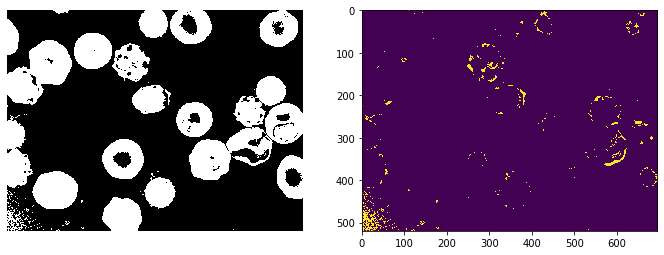

In [28]:
image = skimage.io.imread('Malaria_5Slices_sl1_ch1_p1_t1.tif')
threshold_image = thresholdImage2(image)
connected_image = connected_component_labels(threshold_image)
#plt.imshow(connected_image)

In [7]:
def hough_transform(image):
    #ubyte_image = img_as_ubyte(image)
    #edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)
    my_list = []
    region = measure.regionprops(image)
    i = 0
    for cell in region:
        if cell.area>100:
            radius = int(math.sqrt(((cell).coords[0][1]-(cell).centroid[1])**2
                                   +((cell).coords[0][0]-(cell).centroid[0])**2))
            #hough_res = hough_circle(image, radius)
            circy, circx = circle_perimeter(int(cell.centroid[0]), int(cell.centroid[1]), radius)
            print(circx.shape, circy.shape, image.shape, image.dtype)
            try:
                image[circy, circx] = 255
            except:
                pass
        i+=1
        

In [8]:
def erodeImage(image):
    i = 0
    #label_image = measure.label(image)
    #new_image_label = image
    
    while i<2:
        #thresholded_image = thresholdImage2(new_image_label)
        erode_image = morphology.binary_erosion(label_image)
        new_image_label = measure.label(erode_image)
        i = i +1
    plt.imsave('new_image_label.png', new_image_label)
    plt.imshow(new_image_label, cmap='nipy_spectral')
    return new_image_label

In [9]:
def morphology(skimage_image):
    eroded_image=skimage.morphology.erosion(skimage_image)
    dilated_image=skimage.morphology.dilation(skimage_image)
    opened_image = skimage.morphology.opening(skimage_image)
    closed_image = skimage.morphology.closing(skimage_image)
      
    hist, axes = plt.subplots(4, figsize=(32,24))
    axes[0].imshow(eroded_image, cmap='gray')
    axes[1].imshow(dilated_image, cmap='gray')
    axes[2].imshow(opened_image, cmap='gray')
    axes[3].imshow(closed_image, cmap='gray')

In [21]:
def watershed_segmentation(image):
    image = img_as_ubyte(image)

    denoised = rank.median(image, disk(2))

    # find continuous region (low gradient -
    # where less than 10 for this image) --> markers
    # disk(5) is used here to get a more smooth image
    markers = rank.gradient(denoised, disk(1))<10
    markers = ndi.label(markers)[0]

    # local gradient (disk(2) is used to keep edges thin)
    gradient = rank.gradient(denoised, disk(2))
    
    thr = filters.threshold_yen(image)
    bw_img = image < thr
    bw_img = skimage.morphology.erosion(bw_img,
                                         disk(3))

    # close holes, size check
    label_image = skimage.morphology.remove_small_holes(bw_img,
                                                        area_threshold=625)
    label_image = skimage.morphology.remove_small_objects(label_image,
                                                          min_size=100)
    label_image = measure.label(label_image, background=0)

    markers = skimage.morphology.erosion(label_image,
                                         disk(1))
    # process the watershed
    labels = watershed(gradient, label_image)
    f, ax = plt.subplots(2, 3)
    f.set_size_inches(12, 12)
    ax[0,0].imshow(image)
    ax[0,1].imshow(labels)
    ax[0,2].imshow(bw_img)
    ax[1, 0].imshow(label_image)
    ax[1, 1].imshow(gradient)
    ax[1, 2].imshow(label_image + gradient)
    
    return labels

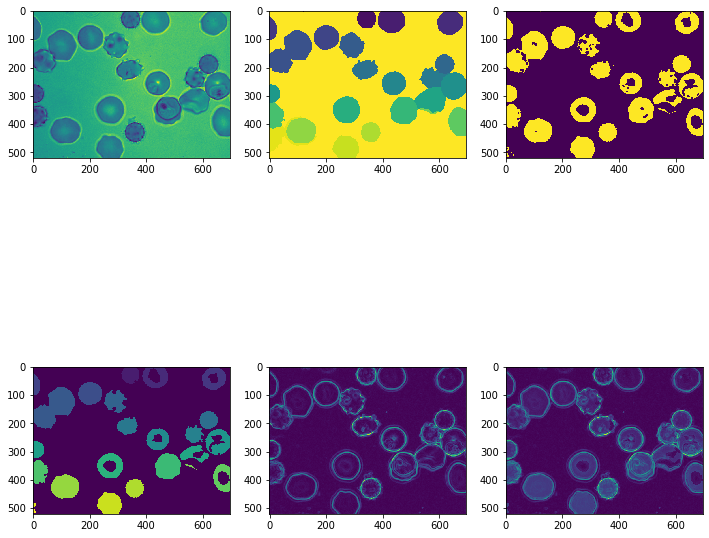

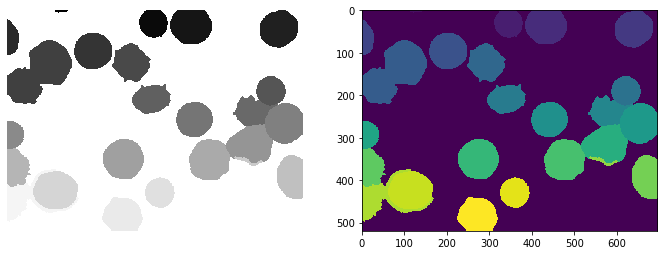

In [29]:
image = skimage.io.imread('Malaria_5Slices_sl1_ch1_p1_t1.tif', flatten=True)
watershed_image = watershed_segmentation(image)
connected_image = connected_component_labels(watershed_image)
#crop_image(connected_image)
plt.imshow(connected_image)

In [13]:
skel_img = skimage.morphology.skeletonize(watershed_image==25)

5106


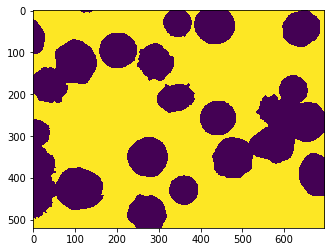

In [16]:
c_idx, r_idx = np.where(skel_img > 0)
print(len(c_idx))
plt.imshow(connected_image==1)
#+ skel_img * 50 , cmap='gray')

In [134]:
?skimage.morphology.thin